In [1]:
from PIL import Image
import os
import shutil
import numpy as np
# import cv2
import re
import pickle
import random
import time
# from tqdm import tqdm
import pandas as pd 
from glob import glob
from xml.etree.ElementTree import parse
# from pascal_voc_writer import Writer
import matplotlib.pyplot as plt

import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.extend(['./detr/'])

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

import sys
sys.path.extend(['./util/'])
from data_parser import *
from image_prepro import *
# from torchvision import transforms

from visualize import *


In [2]:
df = pd.read_csv('df.csv')
# df.drop(columns=['width', 'height'], inplace=True)
df.head()

,label,org_label,width,height,h,w,bbox,xmin,ymin,xmax,ymax,file_name,path
0,Carcinoma,Suamous cell carcinoma,4032,1960,4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,20200623_100015.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
1,HSIL,HSIL,4032,1960,4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
2,HSIL,HSIL,4032,1960,4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
3,HSIL,HSIL,4032,1960,4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
4,HSIL,HSIL,4032,1960,4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...


In [3]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = list(map(int, bbox))

    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
#         print(class_name)
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)

In [4]:
path = '/home/beomgon/Object_Detection/Dataset/SS/01/20200204_135914.jpg'
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.flip(image, 1)
print(image.shape)

(4032, 1960, 3)


In [46]:
df[df['h'] != 1800]['path'][0]

'/home/beomgon/Object_Detection/Dataset/SS/06/20200623_100015.jpg'

(4000, 1800, 3)
        label          org_label  width  height     h     w  \
92713  Normal  No malignant cell   4000    1800  4000  1800   
92714  Normal  No malignant cell   4000    1800  4000  1800   
92715  Normal  No malignant cell   4000    1800  4000  1800   
92716  Normal  No malignant cell   4000    1800  4000  1800   
92717  Normal  No malignant cell   4000    1800  4000  1800   
92718  Normal  No malignant cell   4000    1800  4000  1800   
92719  Normal  No malignant cell   4000    1800  4000  1800   
92720  Normal  No malignant cell   4000    1800  4000  1800   
92721  Normal  No malignant cell   4000    1800  4000  1800   
92722  Normal  No malignant cell   4000    1800  4000  1800   
92723  Normal  No malignant cell   4000    1800  4000  1800   
92724  Normal  No malignant cell   4000    1800  4000  1800   
92725  Normal  No malignant cell   4000    1800  4000  1800   
92726  Normal  No malignant cell   4000    1800  4000  1800   
92727  Normal  No malignant cell   4000

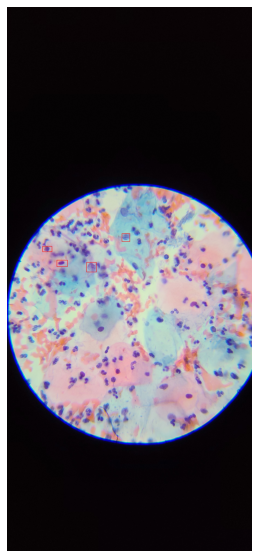

In [50]:
NUM=20000
# print(df[NUM:NUM+1])
path = df.path[NUM]
# path = '/home/beomgon/Object_Detection/Dataset/SS/04/20200513_101513.png' #1560, 1632
# path = '/home/beomgon/Object_Detection/Dataset/SS2/07(201103)/20201103_143345.jpg' #1800, 4000
# path = '/home/beomgon/Object_Detection/Dataset/SS/06/20200623_100015.jpg'
path = '/home/beomgon/Object_Detection/Dataset/SS2/03(200908-10-normal)/20200908_104214.jpg'

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape
if h == 1560 or h == 1800 :
    pass
else :
    image = cv2.flip(image, 1)
print(image.shape)
my_df = df[df['path'] == path].copy()
print(my_df)
my_df.reset_index(inplace=True)
new_bboxes = []
for i in range(len(my_df)) :
    xmin, ymin, xmax, ymax = my_df.loc[i, 'xmin'], my_df.loc[i, 'ymin'], my_df.loc[i, 'xmax'], my_df.loc[i, 'ymax']
    if h == 1560 or h == 1800 :
        new_bboxes.append([xmin, ymin, xmax, ymax])
    else :
        new_bboxes.append([ymin, xmin, ymax, xmax])

category_ids = [0, 1, 1, 1]
category_id_to_name = {0: 'Carcinoma', 1: 'normal'}
visualize(image, new_bboxes, category_ids, category_id_to_name)

In [6]:
# df[df['path'] == '/home/beomgon/Object_Detection/Dataset/SS/04/20200513_101513.png']
# df[df['path'] == '/home/beomgon/Object_Detection/Dataset/SS/04/20200518_095828.png']


In [11]:
transforms = A.Compose([
#     A.RandomCrop(width=450, height=450),
#     A.HorizontalFlip(p=1),
    A.CenterCrop(1560,1560, True,1),
#     A.RandomCrop(height=800, width=800, p=0.5),
#     A.Resize(height=512, width=512, p=1),
#     A.Resize(height=256, width=256, p=1),
    
#     A.OneOf([
#     A.HorizontalFlip(p=0.9),
#     A.VerticalFlip(p=0.9),
#     A.RandomRotate90(p=0.9),        
#     ], p=1),
# #     A.GaussNoise(p=0.5),
#     A.OneOf([
#     A.OpticalDistortion(p=0.7),
#     A.GaussNoise(p=0.7)        
#     ], p=1),
#     A.RandomBrightnessContrast(p=0.2),
#     A.Normalize(max_pixel_value=1),
#     ToTensorV2(p=1.0),
    A.pytorch.ToTensor(),
# ], p=1.0, bbox_params=A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0.5))
], p=1.0, bbox_params=A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0.5, label_fields=['labels'])) 

In [25]:
path = '/home/beomgon/Object_Detection/Dataset/SS/04/20200513_101513.png'
# path = '/home/beomgon/Object_Detection/Dataset/SS/04/20200518_095828.png'
# path = '/home/beomgon/Object_Detection/Dataset/SS/04/20200518_143335.png'
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape
print(image.shape)
if h == 1560 or h == 1800 :
    pass
else :
    image = cv2.flip(image, 1)
my_df = df[df['path'] == path].copy()
my_df.reset_index(inplace=True)
new_bboxes = []
for i in range(len(my_df)) :
    xmin, ymin, xmax, ymax = my_df.loc[i, 'xmin'], my_df.loc[i, 'ymin'], my_df.loc[i, 'xmax'], my_df.loc[i, 'ymax']
    if h == 1560 or h == 1800 :
        new_bboxes.append([xmin, ymin, xmax, ymax])
    else :
        new_bboxes.append([ymin, xmin, ymax, xmax])    

# new_bboxes = new_bboxes[:4]    
# print(new_bboxes)
new_bboxes

(1560, 1632, 3)


[[321, 193, 411, 297],
 [466, 186, 605, 290],
 [339, 327, 461, 496],
 [250, 446, 362, 560],
 [448, 499, 526, 603],
 [525, 516, 622, 604],
 [494, 601, 618, 675],
 [503, 670, 587, 762],
 [390, 650, 497, 748],
 [474, 769, 599, 859],
 [536, 866, 645, 940],
 [440, 927, 562, 1038],
 [286, 1053, 406, 1130],
 [251, 1134, 350, 1218],
 [483, 1058, 586, 1147],
 [580, 1000, 711, 1078],
 [646, 533, 738, 650],
 [742, 491, 872, 646],
 [616, 330, 726, 462],
 [794, 89, 889, 204],
 [886, 64, 984, 150],
 [889, 230, 1024, 365],
 [1158, 318, 1232, 397],
 [1267, 350, 1343, 435],
 [1454, 291, 1558, 388],
 [1337, 542, 1466, 631],
 [749, 672, 843, 781],
 [1388, 814, 1520, 954],
 [1529, 867, 1612, 1002],
 [709, 1055, 810, 1182],
 [1374, 1234, 1483, 1388],
 [1493, 1256, 1577, 1376],
 [991, 1310, 1128, 1450],
 [1129, 1231, 1226, 1328],
 [624, 1234, 750, 1326],
 [464, 1182, 562, 1290],
 [683, 1334, 787, 1448],
 [798, 1334, 935, 1430],
 [843, 1158, 944, 1276],
 [685, 11, 781, 102],
 [431, 7, 547, 131],
 [1088, 497,

In [24]:

transformed = transforms(image=image, bboxes=new_bboxes, labels=[1]*len(new_bboxes))
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['labels']

(321, 193, 411, 297, 1)
(1,)
(0.19669117647058823, 0.12371794871794872, 0.25183823529411764, 0.19038461538461537, 1)
(466, 186, 605, 290, 1)
(1,)
(0.2855392156862745, 0.11923076923076924, 0.3707107843137255, 0.1858974358974359, 1)
(339, 327, 461, 496, 1)
(1,)
(0.20772058823529413, 0.20961538461538462, 0.2824754901960784, 0.31794871794871793, 1)
(250, 446, 362, 560, 1)
(1,)
(0.15318627450980393, 0.2858974358974359, 0.22181372549019607, 0.358974358974359, 1)
(448, 499, 526, 603, 1)
(1,)
(0.27450980392156865, 0.31987179487179485, 0.32230392156862747, 0.38653846153846155, 1)
(525, 516, 622, 604, 1)
(1,)
(0.32169117647058826, 0.33076923076923076, 0.38112745098039214, 0.3871794871794872, 1)
(494, 601, 618, 675, 1)
(1,)
(0.30269607843137253, 0.3852564102564103, 0.3786764705882353, 0.4326923076923077, 1)
(503, 670, 587, 762, 1)
(1,)
(0.3082107843137255, 0.42948717948717946, 0.3596813725490196, 0.48846153846153845, 1)
(390, 650, 497, 748, 1)
(1,)
(0.23897058823529413, 0.4166666666666667, 0.3045

In [10]:
new_bboxes

[[650, 78, 726, 199],
 [687, 187, 760, 299],
 [767, 186, 840, 306],
 [863, 150, 936, 281]]